# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.fit_transform(movie_data.review)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = movie_data['sentiment']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/home/ec2-user/data/moviereviews_train.tsv', my_random_seed=74)

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 5236, 'TN': 4774, 'FP': 5193, 'FN': 4797, 'Accuracy': 0.5005, 'Precision': 0.502061559114009, 'Recall': 0.5218778032492773, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 9633, 'TN': 9811, 'FP': 156, 'FN': 400, 'Accuracy': 0.9722, 'Precision': 0.9840637450199203, 'Recall': 0.9601315658327519, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 10033, 'Neg': 9967, 'TP': 5223, 'TN': 6699, 'FP': 3268, 'FN': 4810, 'Accuracy': 0.5961, 'Precision': 0.615121893769874, 'Recall': 0.5205820791388418, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

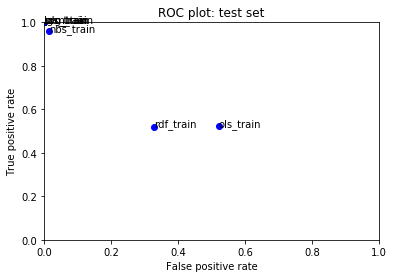

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
13
i tried to sit through this bomb not too long ago.what a disaster .the acting was atrocious.there were some absolutely pathetic action scenes that fell flat as a lead balloon.this was mainly due to the fact that the reactions of the actors just didn't ring true.supposedly a modern reworking of the Hitchcock original \Lifeboat\".i think Hictcock would be spinning circles in his grave at the very thought of it.from what i was able to suffer through,there is nothing compelling in this movie.it boasts a few semi big names,but they put no effort into their characters.but,you know,to be fair,it was nobody's fault really.i mean,i'm pretty sure the script blew up in the first explosion. LOL.it is possible that this thing ends up improving as it goes along.but for me,i'm not willing to spend at least three days to find out.so unless you have at least a three day weekend on the horizon,avoid this stinker/ 1/10"
* * * * * * * * * 
94
the Germans all stand out in th

859
I watched this film alone, in the dark, and it was full moon outside! I didn't do it in purpose, it just happened in this way. So all the elements were there for this film to scare the hell out of me!! Well, it didn't, in fact i wanted to shut off the DVD player after only 8 minutes, but i thought come on give it a chance, unfortunately i did. The acting was awful, the only one with some decent acting was Samaire Armstrong. The plot is not original, if you are a horror fan then it is just the same stuff you have seen many times before. Some scenes didn't make sense at all, and you just get the feeling that the director wanted to make the movie longer! The monster was the biggest disappointment of the movie. The (scary) scenes looked like they belong to a horror movie from the 80s when there was not enough technology, yet some good movies were made back then! I was surprised to see the name of a major production company at the beginning of the movie, i thought couldn't they put some

4026
If this documentary had not been made by the famous French director, Louis Malle, I probably would have turned it off after the first 15 minutes, as it was an incredibly dull look at a very ordinary Midwestern American town in 1979. This is not exactly my idea of a fun topic and the film footage closely resembled a collection of home movies. Considering I didn't know any of these people, it was even less interesting.<br /><br />Because it was a rather dull slice of life style documentary, I wondered while watching what was the message they were trying to convey? Perhaps it was that values aren't as conservative as you might think--this was an underlying message through many of the vignettes (such as the Republicans whose son was a draft resister as well as the man and lady who thought sex outside of marriage was just fine). Or, perhaps the meaning was that there was a lot of bigotry underlying the nice home town--as several ugly ideas such as blaming Jews for financial conspiracie

4869
I saw this film at a pre-release screening at the Writers Guild theater in Beverly Hills. As I recall, the film's producers and director were in attendance, presumably to gage our reaction.<br /><br />Many scenes evoked gales of laughter from the audience, which would have been fine if it had been a comedy, but it was supposed to be a horror film.<br /><br />If the audience wasn't scared, it seems the filmmakers were. They delayed release for over a year. Out of curiosity I saw it again to see if they'd re-cut it; as far as I can tell, they hadn't. It was the same lousy movie, just a year older.<br /><br />It almost qualifies as \so bad, it's good,\" but it's slow-paced and boring."
* * * * * * * * * 
4872
I rented this movie last week. I saw Kevin Spacey and Morgan Freeman were on it, so it seemed promising. And it was, until Justin Timberlake came on scene. He is a really bad actor and shouldn't be allowed to make a movie ever again. I mean, he is one of the most boring, uninspi

* * * * * * * * * 
7203
This movie was absolutely pathetic. A pitiful screenplay and lack of any story just left me watching three losers drool over bikini babes. At times I felt like I was watching an episode of Beavis and Butthead. I couldn't even sit through the whole movie. Emran Hashmi disappoints, and Hrshitta Bhatt is not impressive at all. Celina Jaitley was not bad. The only worthwhile part of the film is the spoof on Anu Malik and his obsession of shayaris. It was pretty hilarious. The songs \Sini Ne\" and its remix version were really good. You can always count on Emran lip-locking and lip-synching a chartbuster. All in all, it seems Emran doesn't have a good script from the Bhatts to back him up this time."
* * * * * * * * * 
7227
A particularly maligned example of Italian cult cinema with a nonsensical title to boot (if anything, the alternate THE MARK OF Satan is even less relevant to the plot!), this hybrid of Gothic Horror and Giallo (with a strong dose of Erotica) only

8305
This programme bugs me! There is no humour to it and is far too serious to be called \fun\"! It's just far too educational for my liking! The characters are very stereotyped and unappealing. The plots are redundant and the morals are just repeated over and over again. Where's the fun in it? Also I feel this has been on the BBC for far too long and is broadcast way too much. Does it really need to have a slot on T.V every 2 or 3 months when a brand new show runs out of episodes? I think it's time that the BBC starting bringing back some of their older shows like: Inspector Gadget, Bananaman, The Smurfs, Snorks, Moomins, the Raccoons and Count Duckula other than continually giving contracts to these newer shows! I thought the BBC where bring back Danger Mouse, so what's going on with that?! 3/10"
* * * * * * * * * 
8370
**WARNING: POSSIBLE SPOILER**<br /><br />If you can get by the extremely unpleasant subject matter, this film does offer a heaping helping of outrageously campy melo

* * * * * * * * * 
10349
This ranks as one of the worst movies I've seen in years. Besides Cuba and Angie, the acting is actually embarrassing. Wasn't Archer once a decent actress? What happened to her? The action is decent but completely implausible. The make up is so bad it's worth mentioning. I mean, who ever even thinks about the makeup in a contemporary feature film. Someone should tell the make up artist, and the DOP that you're not supposed to actually see it. The ending is a massive disappointment - along the lines of \and then they realized it was all a dream\"<br /><br />Don't waste your time or your money. You're better off just staring into space for 2 hours."
* * * * * * * * * 
10399
This really doesn't match up to Castle of Cagliostro. Lupin isn't as funny or wacky or as hyperactive. The scenery and music are uninspired and plot just isn't interesting. <br /><br />The only good thing about this 'un is the nudity (only in the uncut version) provided by Fujiko. It helped sp

11584
in this movie, joe pesci slams dunks a basketball. joe pesci...<br /><br />and being consistent, the rest of the script is equally not believable.<br /><br />pesci is a funny guy, which saves this film from sinking int the absolute back of the cellar, but the other roles were pretty bad. the father was a greedy businessman who valued money more than people, which wasn't even well-played. instead of the man being an archetypal villain, he seemed more like an amoral android programmed to make money at all costs. then there's the token piece that is assigned to pesci as a girlfriend or something...i don't even remember...she was that forgettable.<br /><br />anyone who rates this movie above a 5 or 6 is a paid member of some sort of film studio trying to up the reputation of this sunken film, or at least one of those millions of media minions who can't critique efficiently (you know, the people who feel bad if they give anything a mark below 6).<br /><br />stay away...far away. and s

13629
I'm not ruining anything when I inform you that you get to see a woman have sex with a goat in this movie. If that is your thing, then your movie has arrived.<br /><br />A woman and her husband go to see her estranged sister in the family mansion in the woods. Her sister is a creepy lady to say the least, and she seems to have interests that go beyond family love. On the side a group of unsavory characters show up and begin enacting all kinds of pagan rituals.<br /><br />The plotting is pretty weak and the characters are pretty dumb. The woman sticks around even after her husband starts turning into a jerk and hanging out with the pagans, even continues the have sex with him. On the exploitative side of things, there is much bared flesh and a couple of kinky couplings, but nothing that hasn't been better somewhere else. Oh, and the aforementioned goat-sex scene.<br /><br />Most viewers won't make it to the end. Exploitation fans will ride it out, but will be left wanting more.<br

15029
The story idea is excellent. Unfortunately, the execution lets it down.<br /><br />The movie lacks pace, for one thing. It should be an exciting ride, but it is slow and more than a little boring.<br /><br />I think the problem's mainly in the screenplay and editing. There aren't enough obstacles and reversals to ratchet up suspense, and there are scenes which don't really move the story along very effectively.<br /><br />The producers should have seen this in the screenplay and insisted upon a major rewrite. Unfortunately, when the producer is also the writer and the director, this evidently ain't gonna happen.<br /><br />Much of the acting seems kind of flat, and that is down to the director - all the actors have been quite competent in other projects.<br /><br />It's a shame, because with better writing, editing and direction, this could have been a really good thriller.
* * * * * * * * * 
15059
This movie is phoniness incarnate, a straight 11 / 10 on the phoniness scale. The 

16986
Uh oh! Another gay film. This time it's showing the black side. Bet your last dollar it's gonna have an unhappy ending! But WHY? With only less than a half dozen exceptions, ALL gay films have to end in death or an \addio\" finale. It's like all the European Film Noir releases in the 40's, 50's, 60's, and 70's. The lead...male or female must die or ride off alone into oblivion. Why in God's name must writers, directors, and producers have the audience leave the theatre feeling depressed? After all, it's supposed to be gay...not glum. Maybe the category should be changed to a 'glum' film. A large percentage of gay relationships DO last and the couples DO ride off together into the sunset! No matter who writes or produces, he only shows the down side of gay life and gives the incorrect impression of gay lifestyle. This movie just proves my point. If you rent the DVD, take an antidepressant, for here comes another 'gay' film! This is WRONG!"
* * * * * * * * * 
17042
The script was V

18327
I usually check out the MTV movie awards to watch a witty, entertaining show that delivers a unique award show (Chewbacca winning a life-time achievement award as example). So this year was no different. While I'm not a fan of Justin Timberlake, Seann William Scott has always been funny-albiet stupid-to me. I've laughed at Stiffler in both American Pie movies, and even enjoyed him in Dude Where's My Car?. But the MTV movie awards were simply horrible. Nothing was coherrent, humorous, or entertaining. Justin Timberlake should stick to singing and dancing; he sure as hell can't act.<br /><br />I'm curious as to who the writers were for this show. Last year's performance by Jack Black and Sarah Michelle Gellar was extremly funny (The Lord of the Rings parody alone was worth watching the entire show), but this year was completly different. Did anyone understand Timberlake's comments regarding Luke Wilson and Kate Hudson (\They're staring in a movie together, but have never met! Here 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 1325, 'TN': 1127, 'FP': 1406, 'FN': 1142, 'Accuracy': 0.4904, 'Precision': 0.4851702673013548, 'Recall': 0.5370895824888529, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2040, 'TN': 2086, 'FP': 447, 'FN': 427, 'Accuracy': 0.8252, 'Precision': 0.8202653799758746, 'Recall': 0.8269152817186867, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2065, 'TN': 2074, 'FP': 459, 'FN': 402, 'Accuracy': 0.8278, 'Precision': 0.8181458003169572, 'Recall': 0.8370490474260235, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 1768, 'TN': 1907, 'FP': 626, 'FN': 699, 'Accuracy': 0.735, 'Precision': 0.7385129490392648, 'Recall': 0.7166599108228617, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2034, 'TN': 2090, 'FP': 443, 'FN': 433, 'Accuracy': 0.8248, 'Precision': 0.8211546225272507, 'Recall': 0.8244831779489258, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2103, 'TN': 2102, 'FP': 431, 'FN': 364, 'Accuracy': 0.841, 'Precision': 0.82991318074191, 'Recall': 0.8524523713011756, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 1253, 'TN': 1725, 'FP': 808, 'FN': 1214, 'Accuracy': 0.5956, 'Precision': 0.6079573022804464, 'Recall': 0.5079043372517228, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

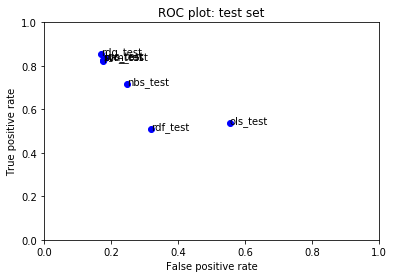

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.53836


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,0
1,8348_2,1
2,5828_4,0
3,7186_2,1
4,12128_7,1


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation